In [1]:
%autosave 0

Autosave disabled


# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [3]:
print(train_files[2], '\n', train_targets[2])

dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_06014.jpg 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [4]:
import random
random.seed(853092)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [5]:
import cv2

Number of faces detected: 1


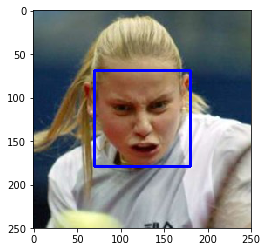

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[19])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

#print ('imagedata\n',gray.shape)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    if len(faces) == 0 and img_path.startswith('lfw'):
        print(img_path)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.


__Answer:__ 

- What percentage of the first 100 images in `human_files` have a detected human face? 
      The human face detector works accurately 99% of the time, misses 1 face (idx=6, as seen above).
- What percentage of the first 100 images in `dog_files` have a detected human face? 
      11% of the dog faces are incorrectly identified as human faces.

In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

#print (face_detector(dog_files_short[10]))
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

h_det = list(map(face_detector, human_files_short))
d_det = list(map(face_detector, dog_files_short))


lfw/Harrison_Ford/Harrison_Ford_0003.jpg


In [9]:
print ('{}\n{}'.format(sum(h_det),sum(d_det)))

99
11


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ 

    In the real world, this is not a reasonable request. A human can recognize a face even without a clear view of the face, e.g. sideways, tilted, or even upside-down.
    For our checkimg, let's try out an mlp first, and then the CNN (using models as-is from the aind-cnn project)

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

Reference: https://hjweide.github.io/efficient-image-loading

In [10]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.


In [11]:
# First the MLP

# We need to load the human faces into x_train, y_train, x_test, y_test
#cv2.CV_LOAD_IMAGE_GRAYSCALE has an integer value of 0. use that in imread

def getX(image_dir):
    data = np.empty((len(image_dir), 62500), dtype=np.uint8)
    labels = np.empty((len(image_dir), 2), dtype=np.uint8)
    for i, fpath in enumerate(image_dir):
        #cv2.CV_LOAD_IMAGE_GRAYSCALE has an integer value of 0. use that in imread
        img = cv2.imread(fpath, 0)
        if img.shape is not (250, 250):
            img = cv2.resize(img, (250,250))
        img = img.flatten()
        data[i, ...] = img
        labels[i] = [1,0] if 'lfw' in fpath else [0, 1]
        
    return data,labels

def load_human_and_dog_faces(tr=100, vl=25, ts=50):
    tr_data, tr_labels = getX(np.concatenate([human_files[:tr], train_files[:tr]]))
    vl_data, vl_labels = getX(np.concatenate([human_files[tr:tr+vl], train_files[tr:tr+vl]]))
    ts_data, ts_labels = getX(np.concatenate([human_files[tr+vl:tr+vl+ts], train_files[tr+vl:tr+vl+ts]]))
    return tr_data, tr_labels, vl_data, vl_labels, ts_data, ts_labels


x_train, y_train, x_valid, y_valid, x_test, y_test = load_human_and_dog_faces(tr=500, vl=50, ts=50)

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

num_classes = 2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

# define the model
model = Sequential()
model.add(Dense(6250, input_shape=(62500,), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.8))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

run_fit = False #set to True when ready to run fit()
#model.summary()

from keras.callbacks import ModelCheckpoint   

if run_fit:
    # train the model, and save the best 
    checkpointer = ModelCheckpoint(filepath='MLP.human.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
    hist = model.fit(x_train, y_train, batch_size=32, epochs=2,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)
    # load the weights that yielded the best validation accuracy
    model.load_weights('MLP.human.weights.best.hdf5')
    # evaluate and print test accuracy
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\n', 'Test accuracy:', score[1])


(1000, 62500) (1000, 2) (100, 62500) (100, 2) (100, 62500) (100, 2)


<pre>
(1000, 62500) (1000, 2) (100, 62500) (100, 2) (100, 62500) (100, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_1 (Dense)              (None, 6250)              390631250 
_________________________________________________________________
dense_2 (Dense)              (None, 512)               3200512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
=================================================================
Total params: 394,095,444.0
Trainable params: 394,095,444.0
Non-trainable params: 0.0
_________________________________________________________________
Train on 1000 samples, validate on 100 samples
Epoch 1/2
Epoch 00000: val_loss improved from inf to 8.05905, saving model to MLP.human.weights.best.hdf5
650s - loss: 8.1076 - acc: 0.4970 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/2
Epoch 00001: val_loss did not improve
186s - loss: 8.0752 - acc: 0.4990 - val_loss: 8.0590 - val_acc: 0.5000

 Test accuracy: 0.5
 </pre>

In [19]:
# Then the Conv2D

#Load the images in as color 3D because Conv2D can handle multi-dim inputs while perceptron needs a vector

def getX(image_dir):
    data = np.empty((len(image_dir), 250, 250, 3), dtype=np.uint8)
    labels = np.empty((len(image_dir), 2), dtype=np.uint8)
    for i, fpath in enumerate(image_dir):
        img = cv2.imread(fpath)
        if img.shape[0] is not 250 or img.shape[1] is not 250:
            img = cv2.resize(img, (250,250))
        #img = img.transpose(2, 0, 1)
        data[i, ...] = img
        labels[i] = [1,0] if 'lfw' in fpath else [0, 1]
        
    return data,labels

def load_human_and_dog_faces(tr=100, vl=25, ts=50):
    tr_data, tr_labels = getX(np.concatenate([human_files[:tr], train_files[:tr]]))
    vl_data, vl_labels = getX(np.concatenate([human_files[tr:tr+vl], train_files[tr:tr+vl]]))
    ts_data, ts_labels = getX(np.concatenate([human_files[tr+vl:tr+vl+ts], train_files[tr+vl:tr+vl+ts]]))
    return tr_data, tr_labels, vl_data, vl_labels, ts_data, ts_labels


x_train, y_train, x_valid, y_valid, x_test, y_test = load_human_and_dog_faces(tr=500, vl=50, ts=50)

#testpath='lfw/Harrison_Ford/Harrison_Ford_0003.jpg'
#testpath = 'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'
#print(testpath)
#img = cv2.imread(testpath)
#print(img.shape)
#print(img.shape[0] is not 250 and img.shape[1] is not 250)
#img = cv2.resize(img,(250,250))
#print(img.shape)
#img = img.transpose(2, 0, 1)
#print(img.shape)
#print(cv2.resize(img,(250,250)).shape)
#print(img)

In [20]:
print(x_train.shape, y_train.shape)

(1000, 250, 250, 3) (1000, 2)


In [27]:
print(x_train.shape, y_train.shape)

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', 
                        input_shape=(250, 250, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

model.summary()

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

(1000, 250, 250, 3) (1000, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 250, 250, 16)      208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 125, 125, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 32)      2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 31, 31, 64

In [28]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)

In [ ]:
# DO NOT re-run this cell. Takes a very long time. Output is described in the cell below.
from keras.callbacks import ModelCheckpoint   

batch_size = 32
epochs = 50

# train the model
checkpointer = ModelCheckpoint(filepath='aug_model.human.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

<pre>
Epoch 1/100
Epoch 00000: val_loss improved from inf to 7.72325, saving model to aug_model.human.weights.best.hdf5
53s - loss: 8.1648 - acc: 0.4909 - val_loss: 7.7233 - val_acc: 0.5208
Epoch 2/100
Epoch 00001: val_loss did not improve
47s - loss: 8.0281 - acc: 0.5019 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 3/100
Epoch 00002: val_loss improved from 7.72325 to 7.58499, saving model to aug_model.human.weights.best.hdf5
48s - loss: 7.9452 - acc: 0.5071 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 4/100
Epoch 00003: val_loss did not improve
47s - loss: 8.0590 - acc: 0.5000 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 5/100
Epoch 00004: val_loss did not improve
47s - loss: 8.1210 - acc: 0.4962 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/100
Epoch 00005: val_loss did not improve
46s - loss: 8.0769 - acc: 0.4989 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/100
Epoch 00006: val_loss did not improve
47s - loss: 7.9940 - acc: 0.5040 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 8/100
Epoch 00007: val_loss improved from 7.58499 to 6.87389, saving model to aug_model.human.weights.best.hdf5
50s - loss: 8.1551 - acc: 0.4940 - val_loss: 6.8739 - val_acc: 0.5735
Epoch 9/100
Epoch 00008: val_loss did not improve
46s - loss: 8.1094 - acc: 0.4969 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 10/100
Epoch 00009: val_loss did not improve
47s - loss: 7.9305 - acc: 0.5080 - val_loss: 7.8912 - val_acc: 0.5104
Epoch 11/100
Epoch 00010: val_loss did not improve
47s - loss: 8.2557 - acc: 0.4878 - val_loss: 9.7183 - val_acc: 0.3971
Epoch 12/100
Epoch 00011: val_loss did not improve
47s - loss: 7.9274 - acc: 0.5082 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 13/100
Epoch 00012: val_loss did not improve
47s - loss: 7.9599 - acc: 0.5061 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 14/100
Epoch 00013: val_loss did not improve
47s - loss: 8.3030 - acc: 0.4849 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 15/100
Epoch 00014: val_loss did not improve
47s - loss: 7.9777 - acc: 0.5050 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 16/100
Epoch 00015: val_loss did not improve
47s - loss: 8.0281 - acc: 0.5019 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 17/100
Epoch 00016: val_loss did not improve
47s - loss: 7.8639 - acc: 0.5121 - val_loss: 6.8739 - val_acc: 0.5735
Epoch 18/100
Epoch 00017: val_loss did not improve
47s - loss: 8.3161 - acc: 0.4841 - val_loss: 7.1109 - val_acc: 0.5588
Epoch 19/100
Epoch 00018: val_loss did not improve
47s - loss: 8.0281 - acc: 0.5019 - val_loss: 7.3480 - val_acc: 0.5441
Epoch 20/100
Epoch 00019: val_loss did not improve
47s - loss: 7.9615 - acc: 0.5061 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 21/100
Epoch 00020: val_loss did not improve
47s - loss: 7.8933 - acc: 0.5103 - val_loss: 6.8739 - val_acc: 0.5735
Epoch 22/100
Epoch 00021: val_loss did not improve
48s - loss: 8.5290 - acc: 0.4708 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 23/100
Epoch 00022: val_loss did not improve
52s - loss: 7.8833 - acc: 0.5109 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 24/100
Epoch 00023: val_loss did not improve
48s - loss: 7.9483 - acc: 0.5069 - val_loss: 9.2442 - val_acc: 0.4265
Epoch 25/100
Epoch 00024: val_loss did not improve
49s - loss: 8.0590 - acc: 0.5000 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 26/100
Epoch 00025: val_loss did not improve
50s - loss: 8.0087 - acc: 0.5031 - val_loss: 7.3480 - val_acc: 0.5441
Epoch 27/100
Epoch 00026: val_loss did not improve
52s - loss: 7.9452 - acc: 0.5071 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 28/100
Epoch 00027: val_loss did not improve
50s - loss: 8.2410 - acc: 0.4887 - val_loss: 8.3948 - val_acc: 0.4792
Epoch 29/100
Epoch 00028: val_loss did not improve
50s - loss: 8.0869 - acc: 0.4983 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 30/100
Epoch 00029: val_loss did not improve
50s - loss: 7.9924 - acc: 0.5041 - val_loss: 9.0072 - val_acc: 0.4412
Epoch 31/100
Epoch 00030: val_loss did not improve
50s - loss: 8.0134 - acc: 0.5028 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 32/100
Epoch 00031: val_loss did not improve
50s - loss: 8.1860 - acc: 0.4921 - val_loss: 7.3480 - val_acc: 0.5441
Epoch 33/100
Epoch 00032: val_loss did not improve
51s - loss: 8.0266 - acc: 0.5020 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 34/100
Epoch 00033: val_loss did not improve
50s - loss: 8.2495 - acc: 0.4882 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 35/100
Epoch 00034: val_loss did not improve
50s - loss: 7.9956 - acc: 0.5039 - val_loss: 9.2442 - val_acc: 0.4265
Epoch 36/100
Epoch 00035: val_loss did not improve
50s - loss: 8.1713 - acc: 0.4930 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 37/100
Epoch 00036: val_loss did not improve
52s - loss: 8.1047 - acc: 0.4972 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 38/100
Epoch 00037: val_loss did not improve
51s - loss: 8.0606 - acc: 0.4999 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 39/100
Epoch 00038: val_loss did not improve
50s - loss: 8.1388 - acc: 0.4951 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 40/100
Epoch 00039: val_loss did not improve
50s - loss: 7.8020 - acc: 0.5159 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 41/100
Epoch 00040: val_loss did not improve
51s - loss: 8.2395 - acc: 0.4888 - val_loss: 9.0072 - val_acc: 0.4412
Epoch 42/100
Epoch 00041: val_loss did not improve
51s - loss: 7.9793 - acc: 0.5049 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 43/100
Epoch 00042: val_loss did not improve
51s - loss: 8.0265 - acc: 0.5020 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 44/100
Epoch 00043: val_loss improved from 6.87389 to 6.39983, saving model to aug_model.human.weights.best.hdf5
52s - loss: 7.8345 - acc: 0.5139 - val_loss: 6.3998 - val_acc: 0.6029
Epoch 45/100
Epoch 00044: val_loss did not improve
51s - loss: 8.0916 - acc: 0.4980 - val_loss: 7.3480 - val_acc: 0.5441
Epoch 46/100
Epoch 00045: val_loss did not improve
51s - loss: 8.0118 - acc: 0.5029 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 47/100
Epoch 00046: val_loss did not improve
51s - loss: 8.1566 - acc: 0.4939 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 48/100
Epoch 00047: val_loss did not improve
51s - loss: 8.2511 - acc: 0.4881 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 49/100
Epoch 00048: val_loss did not improve
51s - loss: 7.8020 - acc: 0.5159 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 50/100
Epoch 00049: val_loss did not improve
51s - loss: 8.0622 - acc: 0.4998 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 51/100
Epoch 00050: val_loss did not improve
51s - loss: 7.9321 - acc: 0.5079 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 52/100
Epoch 00051: val_loss did not improve
51s - loss: 8.0265 - acc: 0.5020 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 53/100
Epoch 00052: val_loss did not improve
51s - loss: 8.1063 - acc: 0.4971 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 54/100
Epoch 00053: val_loss did not improve
51s - loss: 7.7501 - acc: 0.5192 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 55/100
Epoch 00054: val_loss did not improve
51s - loss: 8.2689 - acc: 0.4870 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 56/100
Epoch 00055: val_loss did not improve
52s - loss: 8.3014 - acc: 0.4850 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 57/100
Epoch 00056: val_loss did not improve
58s - loss: 7.9599 - acc: 0.5061 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 58/100
Epoch 00057: val_loss did not improve
54s - loss: 8.0281 - acc: 0.5019 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 59/100
Epoch 00058: val_loss did not improve
54s - loss: 7.8980 - acc: 0.5100 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 60/100
Epoch 00059: val_loss did not improve
54s - loss: 8.4299 - acc: 0.4770 - val_loss: 7.3480 - val_acc: 0.5441
Epoch 61/100
Epoch 00060: val_loss did not improve
57s - loss: 7.9599 - acc: 0.5061 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 62/100
Epoch 00061: val_loss did not improve
55s - loss: 8.0753 - acc: 0.4990 - val_loss: 6.8739 - val_acc: 0.5735
Epoch 63/100
Epoch 00062: val_loss did not improve
51s - loss: 8.0265 - acc: 0.5020 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 64/100
Epoch 00063: val_loss did not improve
53s - loss: 8.2348 - acc: 0.4891 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 65/100
Epoch 00064: val_loss did not improve
54s - loss: 8.0753 - acc: 0.4990 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 66/100
Epoch 00065: val_loss did not improve
53s - loss: 7.9793 - acc: 0.5049 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 67/100
Epoch 00066: val_loss did not improve
55s - loss: 8.2201 - acc: 0.4900 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 68/100
Epoch 00067: val_loss did not improve
51s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 69/100
Epoch 00068: val_loss did not improve
54s - loss: 8.0412 - acc: 0.5011 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 70/100
Epoch 00069: val_loss did not improve
54s - loss: 7.8996 - acc: 0.5099 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 71/100
Epoch 00070: val_loss did not improve
56s - loss: 8.0606 - acc: 0.4999 - val_loss: 7.1109 - val_acc: 0.5588
Epoch 72/100
Epoch 00071: val_loss did not improve
57s - loss: 8.0737 - acc: 0.4991 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 73/100
Epoch 00072: val_loss did not improve
53s - loss: 8.0769 - acc: 0.4989 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 74/100
Epoch 00073: val_loss did not improve
57s - loss: 8.1078 - acc: 0.4970 - val_loss: 6.8739 - val_acc: 0.5735
Epoch 75/100
Epoch 00074: val_loss did not improve
54s - loss: 8.0753 - acc: 0.4990 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 76/100
Epoch 00075: val_loss did not improve
56s - loss: 8.0296 - acc: 0.5018 - val_loss: 7.5850 - val_acc: 0.5294
Epoch 77/100
Epoch 00076: val_loss did not improve
56s - loss: 8.0250 - acc: 0.5021 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 78/100
Epoch 00077: val_loss did not improve
58s - loss: 7.9158 - acc: 0.5089 - val_loss: 9.0072 - val_acc: 0.4412
Epoch 79/100
Epoch 00078: val_loss did not improve
57s - loss: 8.2689 - acc: 0.4870 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 80/100
Epoch 00079: val_loss did not improve
55s - loss: 7.7013 - acc: 0.5222 - val_loss: 7.8220 - val_acc: 0.5147
Epoch 81/100
Epoch 00080: val_loss did not improve
56s - loss: 8.3649 - acc: 0.4810 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 82/100
Epoch 00081: val_loss did not improve
57s - loss: 7.8980 - acc: 0.5100 - val_loss: 6.8739 - val_acc: 0.5735
Epoch 83/100
Epoch 00082: val_loss did not improve
57s - loss: 7.6866 - acc: 0.5231 - val_loss: 7.3480 - val_acc: 0.5441
Epoch 84/100
Epoch 00083: val_loss did not improve
56s - loss: 8.3502 - acc: 0.4819 - val_loss: 9.0072 - val_acc: 0.4412
Epoch 85/100
Epoch 00084: val_loss did not improve
58s - loss: 8.1450 - acc: 0.4947 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 86/100
Epoch 00085: val_loss did not improve
55s - loss: 7.7354 - acc: 0.5201 - val_loss: 9.0072 - val_acc: 0.4412
Epoch 87/100
Epoch 00086: val_loss did not improve
52s - loss: 8.2217 - acc: 0.4899 - val_loss: 8.7701 - val_acc: 0.4559
Epoch 88/100
Epoch 00087: val_loss did not improve
55s - loss: 8.2867 - acc: 0.4859 - val_loss: 9.0072 - val_acc: 0.4412
Epoch 89/100
Epoch 00088: val_loss did not improve
56s - loss: 7.9909 - acc: 0.5042 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 90/100
Epoch 00089: val_loss did not improve
54s - loss: 8.0916 - acc: 0.4980 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 91/100
Epoch 00090: val_loss did not improve
52s - loss: 7.8639 - acc: 0.5121 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 92/100
Epoch 00091: val_loss did not improve
54s - loss: 8.1241 - acc: 0.4960 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 93/100
Epoch 00092: val_loss did not improve
54s - loss: 8.2836 - acc: 0.4861 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 94/100
Epoch 00093: val_loss did not improve
54s - loss: 7.9762 - acc: 0.5051 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 95/100
Epoch 00094: val_loss did not improve
57s - loss: 8.1404 - acc: 0.4950 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 96/100
Epoch 00095: val_loss did not improve
53s - loss: 8.0737 - acc: 0.4991 - val_loss: 7.3480 - val_acc: 0.5441
Epoch 97/100
Epoch 00096: val_loss did not improve
54s - loss: 8.0428 - acc: 0.5010 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 98/100
Epoch 00097: val_loss did not improve
54s - loss: 8.0412 - acc: 0.5011 - val_loss: 8.2961 - val_acc: 0.4853
Epoch 99/100
Epoch 00098: val_loss did not improve
53s - loss: 8.1713 - acc: 0.4930 - val_loss: 8.5331 - val_acc: 0.4706
Epoch 100/100
Epoch 00099: val_loss did not improve
57s - loss: 8.1257 - acc: 0.4959 - val_loss: 8.2961 - val_acc: 0.4853
Out[29]:
<keras.callbacks.History at 0x7f11576eb2b0>
</pre>

In [47]:
# load the weights that yielded the best validation accuracy
model.load_weights('aug_model.human.weights.best.hdf5')

# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])



 Test accuracy: 0.5


__Results:__

The MLP seems to take up a really large number of parameters, but quickly settles on to a val_loss value (8.0590) that does not improve over subsequent epochs beyond the 2nd epoch. This I tried with various combinations of 3-deep networks. None of the trials gives loss below 8.0590, or test accuracy better than 0.5, which is really the same as mindlessly predicting all the images to be of one class or the other. The accuracy does not change either with different shuffling of images, or by increasing the training data from 200 to 500 images.

Results of the Conv2D, even thought the loss is much lesser at 6.39983, don't look much different, with the accuracy still being 0.5 - effectively random.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [23]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [24]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [25]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [26]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    #print if any human resembles a canine
    print(img_path) if ((prediction <= 268) & (prediction >= 151)) and 'lfw' in img_path else None
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?


__Answer:__ 
- What percentage of the images in `human_files_short` have a detected dog?
       Only 1% human faces were incorrectly reccognized as dog-face
- What percentage of the images in `dog_files_short` have a detected dog?
        100% of the dog faces were detected correctly by the ResNet-50 Dog Detector.

In [27]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

hres_det = list(map(dog_detector, human_files_short))
dres_det = list(map(dog_detector, dog_files_short))


lfw/George_W_Bush/George_W_Bush_0529.jpg


In [28]:
print ('{}\n{}'.format(sum(hres_det),sum(dres_det)))

1
100


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [29]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 159.13it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.



__Answer:__ 

As mentioned in the videos, the AlexNet was the first one to introduce the Conv-Pool-Dropout architecture with ReLU activation. While computationally intensive this is known to give good results in the image recognition arena. It would be instructional to try out the VGG Architecture along with this one as well.

I use the same exact architecture as suggested above, using 'valid' padding. This is different from the one that I used earlier in the Conv2D example. While keeping the layer sizes as given in the model summary above, I've added 3 Dropout layers. To begin with, I started with a value of 0.2 for the drop-rate. The results though seem to be pretty nice, giving an accuracy of 4.18%, much better than required 1%.

In [30]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
# Start off with the one in the other miniproject (or the same used above!)
# Then modify according to the hint given...

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', 
                        input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 54, 64)        8256      
__________

### Compile the Model

In [31]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [19]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.
# takes about 1:10 to run
epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 209s - loss: 4.8833 - acc: 0.0097 - val_loss: 4.8751 - val_acc: 0.0108
Epoch 2/20
6680/6680 [==============================] - 211s - loss: 4.8631 - acc: 0.0108 - val_loss: 4.8587 - val_acc: 0.0168
Epoch 3/20
6680/6680 [==============================] - 211s - loss: 4.8279 - acc: 0.0181 - val_loss: 4.8267 - val_acc: 0.0240
Epoch 4/20
6680/6680 [==============================] - 211s - loss: 4.7927 - acc: 0.0189 - val_loss: 4.7932 - val_acc: 0.0180
Epoch 5/20
6680/6680 [==============================] - 212s - loss: 4.7642 - acc: 0.0217 - val_loss: 4.7807 - val_acc: 0.0240
Epoch 6/20
6680/6680 [==============================] - 213s - loss: 4.7411 - acc: 0.0207 - val_loss: 4.7579 - val_acc: 0.0204
Epoch 7/20
6680/6680 [==============================] - 217s - loss: 4.7168 - acc: 0.0229 - val_loss: 4.7393 - val_acc: 0.0204
Epoch 8/20
6680/6680 [==============================] - 217s - l

### Load the Model with the Best Validation Loss

In [32]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [33]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.5455%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [34]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [36]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [37]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [38]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.3078 - acc: 0.1228 - val_loss: 10.7876 - val_acc: 0.2060
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.2424 - acc: 0.2823 - val_loss: 10.3575 - val_acc: 0.2695
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 9.8701 - acc: 0.3382 - val_loss: 10.1159 - val_acc: 0.2982
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 9.7435 - acc: 0.3627 - val_loss: 10.0193 - val_acc: 0.3257
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.5790 - acc: 0.3783 - val_loss: 9.8656 - val_acc: 0.3413
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.3366 - acc: 0.3916 - val_loss: 9.5034 - val_acc: 0.3461
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.0272 - acc: 0.4133 - val_loss: 9.3662 - val_acc: 0.3605
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 8.926

### Load the Model with the Best Validation Loss

In [39]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [40]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.9856%


### Predict Dog Breed with the Model

In [41]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [42]:
import random
randomlist = random.sample(range(len(test_files)), 5)

for idx in randomlist:
    print('{:3d} {:25.25} {:25.25}'.format(idx, VGG16_predict_breed(test_files[idx]), dog_names[np.argmax(test_targets[idx])]))


656 American_water_spaniel    Field_spaniel            
180 Dachshund                 Cavalier_king_charles_spa
192 American_water_spaniel    Chow_chow                
776 Parson_russell_terrier    Parson_russell_terrier   
 59 Irish_terrier             Lakeland_terrier         


---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [43]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
# Reason to use Resnet50 - its already downloaded, Inc=1.6GB, eXc=3.1GB not done yet.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.


__Answer:__

We use transfer learning, i.e. pre-tuned set of parameters, to identify the features.

Since we used the similar architecture in the previous step, we'll re-use the same approach (and code!) with the Resnet50 dataset. In the Resnet50 model, the dog features are squeezed into a 2048 vector (GlobalAveragePooling2D) and then a fully-connected layer is used to obtain the predicted probabilities (133 possible breeds).

In [44]:
### TODO: Define your architecture.

Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517.0
Trainable params: 272,517.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [45]:
### TODO: Compile the model.

Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [46]:
### TODO: Train the model.

from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 1.6299 - acc: 0.5951 - val_loss: 0.8417 - val_acc: 0.7605
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 0.4483 - acc: 0.8558 - val_loss: 0.7228 - val_acc: 0.7880
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 0.2697 - acc: 0.9154 - val_loss: 0.6810 - val_acc: 0.8108
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 0.1767 - acc: 0.9433 - val_loss: 0.6612 - val_acc: 0.8036
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 0.1219 - acc: 0.9612 - val_loss: 0.6905 - val_acc: 0.8060
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 0.0919 - acc: 0.9720 - val_loss: 0.6472 - val_acc: 0.8132
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 0.0618 - acc: 0.9831 - val_loss: 0.7225 - val_acc: 0.8048
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 0.0503 - ac

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [47]:
### TODO: Load the model weights with the best validation loss.

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [48]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.0574%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [49]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [50]:
import random
randomlist = random.sample(range(len(test_files)), 5)

for index, idx in enumerate(randomlist, start=1):
    print('{} > {:3d} {:25.25} {:25.25}'.format(index, idx, Resnet50_predict_breed(test_files[idx]), dog_names[np.argmax(test_targets[idx])]))


1 > 329 Golden_retriever          Golden_retriever         
2 > 115 Australian_cattle_dog     Australian_cattle_dog    
3 > 323 Cairn_terrier             Cairn_terrier            
4 >  63 Labrador_retriever        Labrador_retriever       
5 >  42 Cairn_terrier             Cairn_terrier            


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [51]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def show_img(imagefile):
    img = cv2.imread(imagefile)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

def get_dog_breed(imagefile):
    # Same as Resnet50_predict_breed, but dont wrap
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(imagefile))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    sorted_vector = predicted_vector.argsort()[::-1] 
    sorted_probs = predicted_vector[0,sorted_vector]
    sorted_names = np.array(dog_names)[sorted_vector]
    return sorted_names[:, ::-1][:, :3], sorted_probs[:, ::-1][:, :3]

def check_if_human(imagefile):
    num_faces = face_detector(imagefile)
    return num_faces > 0

print('done')

done


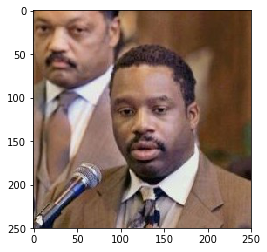

['Beagle' 'Lowchen' 'Boxer']
['0.605', '0.223', '0.106']
Human? = True


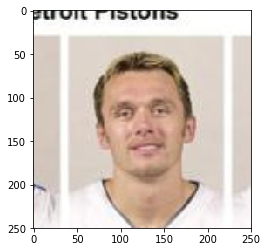

[['Silky_terrier' 'Chinese_crested' 'Beagle']]
['0.450', '0.129', '0.124']
Human? = True


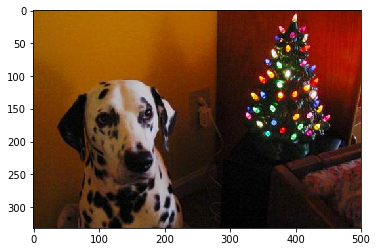

['Dalmatian' 'Great_dane' 'Beagle']
['1.000', '0.000', '0.000']
Human? = False


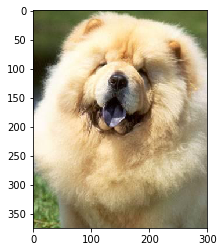

[['Chow_chow' 'Pekingese' 'Akita']]
['1.000', '0.000', '0.000']
Human? = False


In [60]:
#show_img('lfw/George_W_Bush/George_W_Bush_0529.jpg')
#pred_name, pred_prob = get_dog_breed('lfw/George_W_Bush/George_W_Bush_0529.jpg')
#human = check_if_human('lfw/George_W_Bush/George_W_Bush_0529.jpg')
#print(pred_name)
#print(pred_prob)
#print('human = {}'.format(human))

show_img(human_files_short[75])
pred_name, pred_prob = get_dog_breed(human_files_short[75])
human = check_if_human(human_files_short[75])
print(pred_name[0])
print(['%5.3f' % val for val in pred_prob[0]])
print('Human? = {}'.format(human))

show_img(human_files_short[17])
pred_name, pred_prob = get_dog_breed(human_files_short[17])
human = check_if_human(human_files_short[17])
print(pred_name)
print(['%5.3f' % val for val in pred_prob[0]])
print('Human? = {}'.format(human))

show_img(dog_files_short[1])
pred_name, pred_prob = get_dog_breed(dog_files_short[1])
human = check_if_human(dog_files_short[1])
print(pred_name[0])
print(['%5.3f' % val for val in pred_prob[0]])
print('Human? = {}'.format(human))

show_img(dog_files_short[19])
pred_name, pred_prob = get_dog_breed(dog_files_short[19])
human = check_if_human(dog_files_short[19])
print(pred_name)
print(['%5.3f' % val for val in pred_prob[0]])
print('Human? = {}'.format(human))


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

testimages/031.Borzoi/Borzoi_02154.jpg


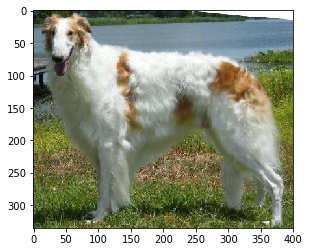

Is human? = False
Borzoi: 1.00000	Australian_shepherd: 0.00000	Collie: 0.00000	

testimages/031.Borzoi/Borzoi_02162.jpg


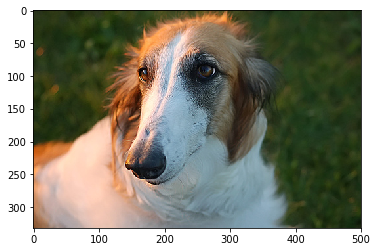

Is human? = False
Borzoi: 0.95343	Irish_red_and_white_setter: 0.01881	Afghan_hound: 0.01413	

testimages/050.Chinese_shar-pei/Chinese_shar-pei_03556.jpg


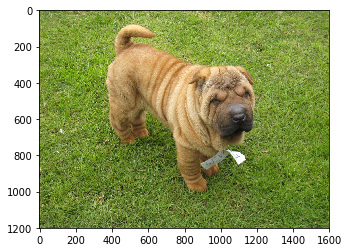

Is human? = True
Chinese_shar-pei: 0.99975	Chow_chow: 0.00024	Akita: 0.00000	

testimages/050.Chinese_shar-pei/Chinese_shar-pei_03580.jpg


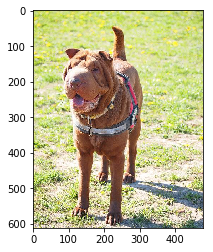

Is human? = False
Dogue_de_bordeaux: 0.96586	Chinese_shar-pei: 0.02569	Chesapeake_bay_retriever: 0.00779	

testimages/071.German_shepherd_dog/German_shepherd_dog_04886.jpg


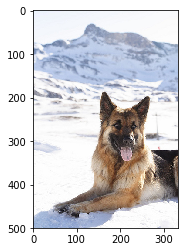

Is human? = False
Belgian_tervuren: 0.57012	German_shepherd_dog: 0.36578	Akita: 0.05651	

testimages/071.German_shepherd_dog/German_shepherd_dog_04938.jpg


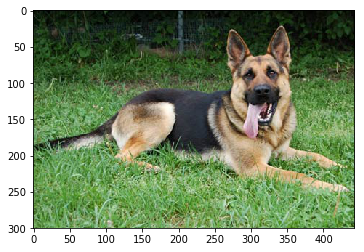

Is human? = False
German_shepherd_dog: 0.99996	Belgian_malinois: 0.00004	Belgian_tervuren: 0.00000	

testimages/125.Portuguese_water_dog/Portuguese_water_dog_07971.jpg


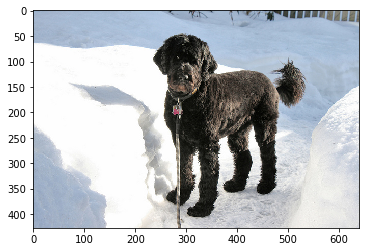

Is human? = False
Poodle: 0.96775	Kerry_blue_terrier: 0.02071	Flat-coated_retriever: 0.00911	

testimages/125.Portuguese_water_dog/Portuguese_water_dog_07984.jpg


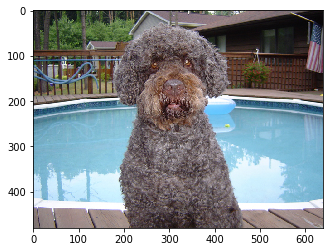

Is human? = False
Lakeland_terrier: 0.31394	Portuguese_water_dog: 0.23764	Irish_water_spaniel: 0.19563	

testimages/Alan_Greenspan/Alan_Greenspan_0003.jpg


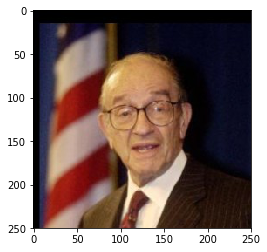

Is human? = True
Beagle: 0.93655	American_foxhound: 0.02908	Silky_terrier: 0.00768	

testimages/Alan_Greenspan/Alan_Greenspan_0004.jpg


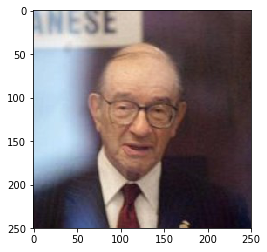

Is human? = True
Beagle: 0.30396	English_toy_spaniel: 0.24552	American_foxhound: 0.12397	

testimages/Christina_Aguilera/Christina_Aguilera_0003.jpg


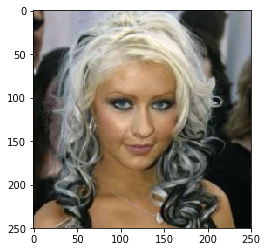

Is human? = True
Silky_terrier: 0.92113	English_toy_spaniel: 0.02294	Chinese_crested: 0.02144	

testimages/Christina_Aguilera/Christina_Aguilera_0004.jpg


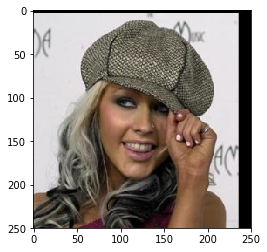

Is human? = True
Chesapeake_bay_retriever: 0.39031	Silky_terrier: 0.20394	Lowchen: 0.10115	

testimages/Jelena_Dokic/Jelena_Dokic_0004.jpg


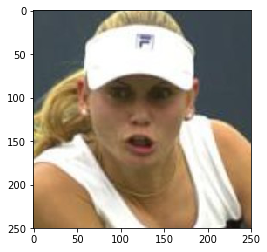

Is human? = True
Silky_terrier: 0.33145	Beagle: 0.25852	Dogue_de_bordeaux: 0.14313	

testimages/Jelena_Dokic/Jelena_Dokic_0008.jpg


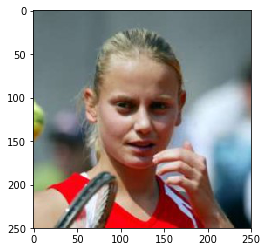

Is human? = True
Silky_terrier: 0.87255	Chihuahua: 0.04609	Dachshund: 0.02525	

testimages/Will_Smith/Will_Smith_0001.jpg


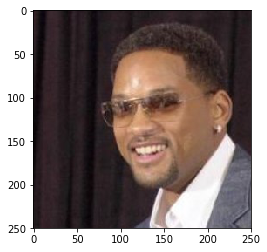

Is human? = True
Silky_terrier: 0.46061	Beagle: 0.45736	American_water_spaniel: 0.02154	

testimages/Will_Smith/Will_Smith_0002.jpg


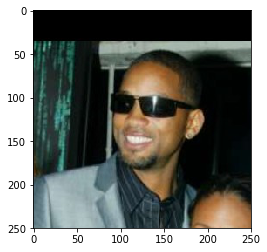

Is human? = True
Silky_terrier: 0.82479	Beagle: 0.06057	English_toy_spaniel: 0.03367	



In [84]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

def make_pred_str(nm, pr):
    pstr = ''
    for idx in range(3):
        pstr += str(nm[0][idx]) + ': ' + '{:.5f}'.format(pr[0][idx]) + '\t'
    return pstr +'\n'

def whosit(somepic):
    pred_str = ''
    print(somepic)
    show_img(somepic)
    pred_name, pred_prob = get_dog_breed(somepic)
    pred_str = make_pred_str(pred_name, pred_prob)
    human = check_if_human(somepic)
    print('Is human? = {}'.format(human))
    print(pred_str)

my_files = np.array(glob("testimages/*/*"))
my_files = np.sort(my_files)
#print(my_files)

for apic in my_files:
    whosit(apic)
    #pass

#print(pred_str(pred_name, pred_prob))